## Check simulations of BDs

In [1]:
import sys
#sys.path.append("../python/")
sys.path.append("/home/mariacst/cluster/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.palettes
import imp
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population, spatial_sampling, rho, IMF_sampling, mock_population_all
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Empirical space densities at the Solar neighbourhood

Data below is taken from Table 15 of [Kirkpatrick + '20](https://arxiv.org/abs/2011.11616)

In [3]:
# temperature [K]
bin_edges = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1950, 2100, 2250] 
# space density [x 1e-3 pc-3]
rho       = [2.84, 4.24, 2.80, 1.99, 1.72, 1.11, 1.95, 0.94, 0.81, 0.78, 0.50, 0.72, 0.31] 
error_rho = [np.nan, 0.70, 0.37, 0.32, 0.30, 0.25, 0.30, 0.22, 0.20, 0.20, 0.17, 0.18, np.nan]

bins = np.zeros(len(rho))

for i in range(len(rho)):
    bins[i] = 0.5*(bin_edges[i] + bin_edges[i+1])

#TODO - need to plot arrows for lower limits

Text(0.5, 0, '$T_{\\rm eff}$ [K]')

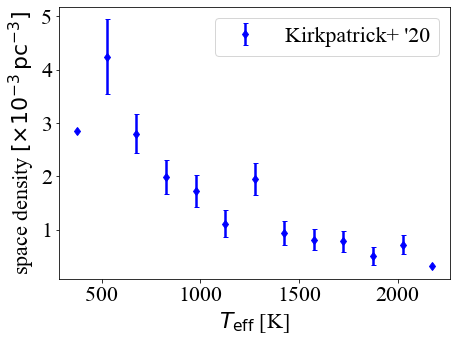

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(bins, rho, error_rho, fmt="d", elinewidth=2.5, capsize=2.5, label="Kirkpatrick+ '20", color="blue")

ax.legend()
ax.set_ylabel(r"space density $\rm [\times 10^{-3}\,pc^{-3}]$")
ax.set_xlabel(r"$T_{\rm eff}$ [K]")

### Spatial distribution

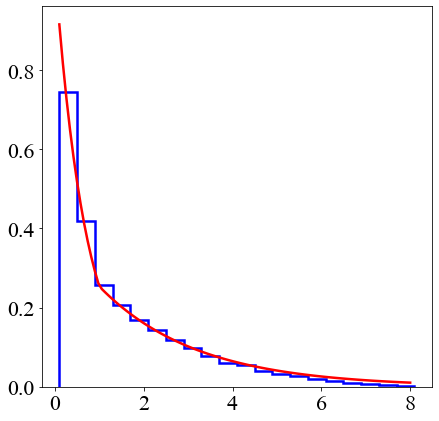

In [31]:
# Checking sampling results

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

radius = np.linspace(0.1, 8., 100)
from scipy.integrate import quad
A = quad(rho, 0.1, 8.178, args=(0., np.pi/2., ))
ax.plot(radius, rho(radius, 0., np.pi/2.)/A[0], color="red", lw=2.5)

_, _, _ = ax.hist(r, histtype="step", linewidth=2.5, color="blue", density=True, bins=20)


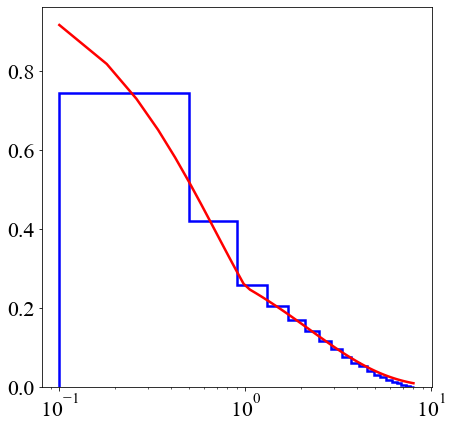

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

radius = np.linspace(0.1, 8., 100)
from scipy.integrate import quad
A = quad(rho, 0.1, 8.178, args=(0., np.pi/2., ))
ax.plot(radius, rho(radius, 0., np.pi/2.)/A[0], color="red", lw=2.5)

_, _, _ = ax.hist(r, histtype="step", linewidth=2.5, color="blue", density=True, bins=20)

ax.set_xscale("log")

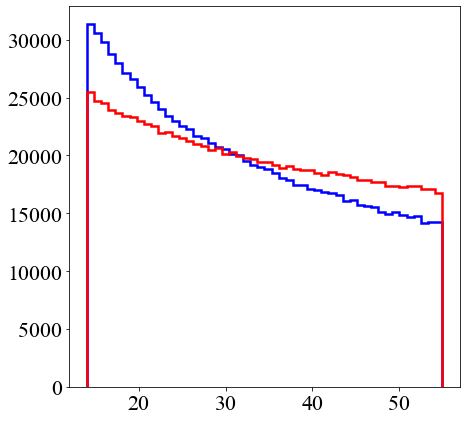

In [14]:
from utils import random_powerlaw

N = 1000000
mass1 = random_powerlaw(-0.6, N, Mmin=14, Mmax=55)
mass2 = random_powerlaw(-0.3, N, Mmin=14, Mmax=55)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_, _, _ = ax.hist(mass1, color="blue", histtype="step", bins=50, linewidth=2.5)
_, _, _ = ax.hist(mass2, histtype="step", color="red", bins=50, linewidth=2.5)

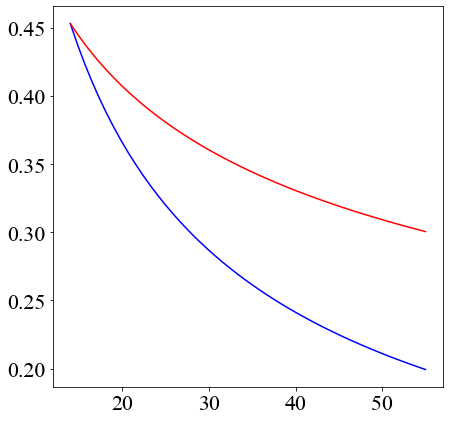

In [11]:
def IMF(M, alpha):
    return np.power(M, -alpha)

M = np.linspace(14, 55)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(M, IMF(14, 0.3)/IMF(14, 0.6)*IMF(M, 0.6), color="blue")
ax.plot(M, IMF(M, 0.3), color="red")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(M, IMF(14, 0.3)/IMF(14, 0.6)*IMF(M, 0.6), color="blue")
ax.plot(M, IMF(M, 0.3), color="red")

## Noise in mass estimate

In [15]:
import sys
sys.path.append("../python/")
import imp

import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mock_population?

In [11]:
_, _, mass1, mass_wn1, _ = mock_population(1000, 0.1, 0.1, 1., 1., 5.)
_, _, mass2, mass_wn2, _ = mock_population(1000, 0.1, 0.2, 1., 1., 5.)

In [14]:
print(np.sum(np.abs(mass_wn1 - mass1)/mass1)/1000*100)
print(np.sum(np.abs(mass_wn2 - mass2)/mass2)/1000*100)

7.872992834442383
15.97226555827462


Text(0.5, 0, '$\\sigma_M$')

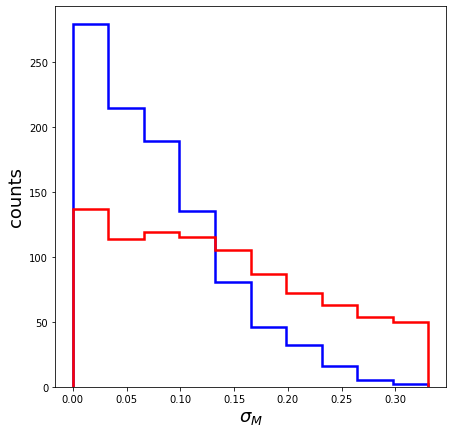

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

counts1, bins, _ = ax.hist(np.abs(mass_wn1 - mass1)/mass1, histtype="step", color="b", lw=2.5)
counts2, _, _    = ax.hist(np.abs(mass_wn2 - mass2)/mass2, histtype="step", color="r", lw=2.5, bins=bins)

ax.set_ylabel("counts", fontsize=18)
ax.set_xlabel(r"$\sigma_M$", fontsize=18)

Text(0.5, 0, '$\\sigma_M$')

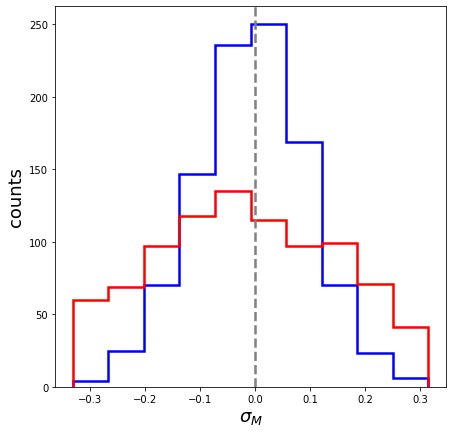

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

counts1, bins, _ = ax.hist((mass_wn1 - mass1)/mass1, histtype="step", color="b", lw=2.5)
counts2, _, _    = ax.hist((mass_wn2 - mass2)/mass2, histtype="step", color="r", lw=2.5, bins=bins)
ax.axvline(0., ls="--", color="grey", lw=2.5)
ax.set_ylabel("counts", fontsize=18)
ax.set_xlabel(r"$\sigma_M$", fontsize=18)

Text(0.5, 0, '$\\sigma_M$')

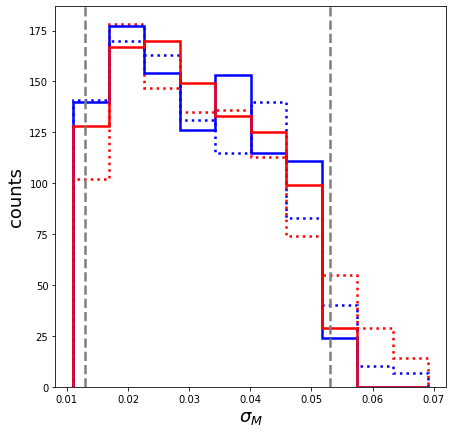

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

_, bins, _ = ax.hist(mass1, histtype="step", color="b", ls=":", lw=2.5)
_, _, _    = ax.hist(mass2, histtype="step", color="r", ls=":", lw=2.5, bins=bins)
counts1, _, _ = ax.hist(mass_wn1, histtype="step", color="b", lw=2.5, bins=bins)
counts2, _, _    = ax.hist(mass_wn2, histtype="step", color="r", lw=2.5, bins=bins)
ax.axvline(0.013, ls="--", color="grey", lw=2.5)
ax.axvline(0.053, ls="--", color="grey", lw=2.5)

ax.set_ylabel("counts", fontsize=18)
ax.set_xlabel(r"$\sigma_M$", fontsize=18)

## DM velocity dispersion

In [5]:
from scipy.special import hyp2f1
from scipy.interpolate import interp1d

def vgNFW(Rsun, R, parameters):
    """
    Rotation velocity for gNFW dark matter density profile
    """
    # gNFW parameters
    gamma = parameters[0]
    Rs    = parameters[1]
    rho0  = parameters[2]
    v     = [];
    for Rint in R:
        hyp=np.float(hyp2f1(3-gamma,3-gamma,4-gamma,-Rint/Rs))
        Integral=(-2**(2+3*gamma)*np.pi*Rint**(3-gamma)*(1+
                  Rsun*(1./Rs))**(3-gamma)*rho0*hyp)/(-3+gamma)
        v.append(np.sqrt(1.18997*10.**(-31.)*Integral/Rint)*3.08567758*10.**(16.))
    v = np.array(v,dtype=np.float64)
    # Return
    return v

def vc(Rsun, Rint, parameters, filepath):
    data = np.genfromtxt(filepath + "rc_e2bulge_R08.178_J_corr.dat", unpack=True)
    r = data[0]
    vB = data[1]
    data = np.genfromtxt(filepath + "rc_hgdisc_R08.178_corr.dat", unpack=True)
    vD = data[1]
    vDM = vgNFW(Rsun, r, parameters)
    vtot = np.sqrt(np.power(vB, 2) + np.power(vD, 2)+ np.power(vDM, 2))
    vtot_intp = interp1d(r, vtot)
    return vtot_intp(Rint)

In [6]:
R0 = 8.178
r  = np.linspace(0.1, R0, 500)
parameters = [0.5, 20., 0.42]
filepath = "/home/mariacst/cluster/data/"

rc = vc(R0, r, parameters, filepath)

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


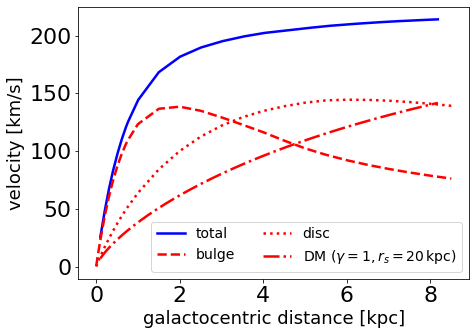

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(r, rc, ls="-", lw=2.5, color="blue", label="total")

data = np.genfromtxt(filepath + "rc_e2bulge_R08.178_J_corr.dat", unpack=True)
rb = data[0]; vb = data[1]
ax.plot(data[0], data[1], ls="--", color="red", label="bulge", lw=2.5)
data = np.genfromtxt(filepath + "rc_hgdisc_R08.178_corr.dat", unpack=True)
rd = data[0]; vd = data[1]
ax.plot(data[0], data[1], ls=":", color="red", label="disc", lw=2.5)
ax.plot(r, vgNFW(R0, r, parameters), ls="-.", color="red", label=r"DM $(\gamma=1, r_s=20\,{\rm kpc})$", lw=2.5)

ax.legend(loc=4, ncol=2, fontsize=14)
ax.set_ylabel("velocity [km/s]", fontsize=18)
ax.set_xlabel("galactocentric distance [kpc]", fontsize=18)
fig.savefig("../../Figs/rc.pdf", bbox_inches="tight")

1.071302605210421 25.596445971806023
0.1 0.1 24.60115486403112
175.29815935912328 95.75660607397832


Text(0.5, 0, 'galactocentric distance [kpc]')

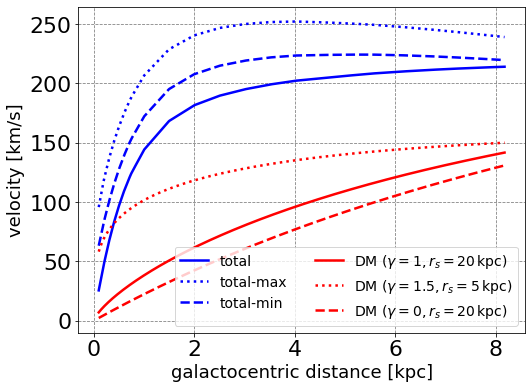

In [12]:
print(r[60], rc[0])
print(rb[4], rd[4], np.sqrt(np.power(vb[4], 2) + np.power(vd[4], 2)))

rc2 = vc(R0, r, [0.5, 20., 0.42], filepath)
rc3 = vc(R0, r, [1.5, 5., 0.42], filepath)

print(rc2[60], rc3[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(r, rc, ls="-", lw=2.5, color="blue", label="total")
ax.plot(r, rc3, ls=":", lw=2.5, color="blue", label="total-max")
ax.plot(r, rc2, ls="--", lw=2.5, color="blue", label="total-min")

ax.plot(r, vgNFW(R0, r, parameters), ls="-", color="red", label=r"DM $(\gamma=1, r_s=20\,{\rm kpc})$", lw=2.5)
ax.plot(r, vgNFW(R0, r, [1.5, 5., 0.42]), ls=":", color="red", label=r"DM $(\gamma=1.5, r_s=5\,{\rm kpc})$", lw=2.5)
ax.plot(r, vgNFW(R0, r, [0., 20., 0.42]), ls="--", color="red", label=r"DM $(\gamma=0, r_s=20\,{\rm kpc})$", lw=2.5)

ax.grid(which="both", ls="--", color="grey")

ax.legend(loc=4, ncol=2, fontsize=14)
ax.set_ylabel("velocity [km/s]", fontsize=18)
ax.set_xlabel("galactocentric distance [kpc]", fontsize=18)
fig.savefig("../../Figs/rc_variation.pdf", bbox_inches="tight")

No handles with labels found to put in legend.


(0.0, 1.0)

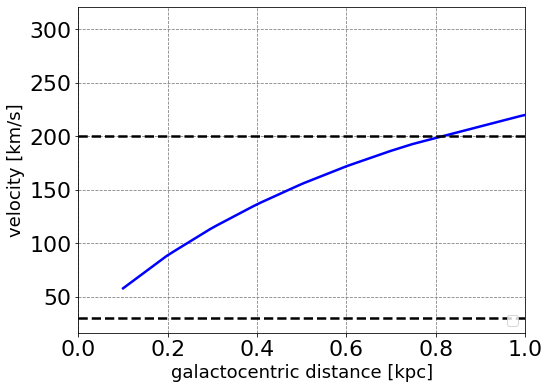

In [17]:
rc = vc(R0, r, [1., 5., 0.42], filepath)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(r, np.sqrt(3/2)*rc, ls="-", lw=2.5, color="blue")
ax.axhline(200., color="k", ls="--", lw=2.5)
ax.axhline(30., color="k", ls="--", lw=2.5)
ax.grid(which="both", ls="--", color="grey")

ax.legend(loc=4, ncol=2, fontsize=14)
ax.set_ylabel("velocity [km/s]", fontsize=18)
ax.set_xlabel("galactocentric distance [kpc]", fontsize=18)
ax.set_xlim(0., 1.)

## GC sampling - test 

In [3]:
def rho_bulge(r, phi, theta, R0=8.178, x0=0.899, y0=0.386, z0=0.250, 
              alpha=0.415):
    """
    Density profile for Stanek + '97 (E2) bulge [arbitrary units]
    (all spatial coordiantes are given in kpc)
    """
    x0 = x0*R0/8. # rescale to adopted R0 value
    y0 = y0*R0/8. 
    # return
    return (np.exp(-np.sqrt(np.sin(theta)**2*((np.cos(phi+alpha)/x0)**2 +
                            (np.sin(phi+alpha)/y0)**2) + 
                            (np.cos(theta)/z0)**2)*r))

def rho_disc(r, theta, R0=8.178, Rd=2.15, zh=0.40):
    """
    Density profile for Bovy and Rix disc [arbitrary units]
    (all spatial coordiantes are given in kpc)
    """
    Rd = Rd*R0/8. # rescale to adopted R0 value
    # return
    return np.exp(-r*np.sin(theta)/Rd)*np.exp(-r*np.cos(theta)/zh)


def rho(r, phi, theta, R0=8.178):
    """
    Density profile [arbitrary units]
    """
    # continuity condition at r = 1 kpc
    C    = rho_disc(1., theta, R0)/rho_bulge(1., phi, theta, R0)
    _rho = C*rho_bulge(r, phi, theta, R0)
    # return
    return (np.heaviside(1.-r, 1.)*_rho +
            np.heaviside(r-1., 0.)*rho_disc(r, theta, R0))

def spatial_sampling(nBDs, phi=0., theta=np.pi/2., R0=8.178):
    """
    Sampling nBDs points from density profile rho using Von Neumann 
    acceptance-rejection technique
    """
    ymin = 0.1; ymax = 1.0
    umin = np.min([rho(ymin, phi, theta), rho(1., phi, theta),
                   rho(R0, phi, theta)])
    umax = np.max([rho(ymin, phi, theta), rho(1., phi, theta),
                   rho(R0, phi, theta)])

    i = 0
    r = np.ones(nBDs)*100
    while i<nBDs:
        yi = np.random.uniform(ymin, ymax)
        ui = np.random.uniform(umin, umax)
        if ui < rho(yi, phi, theta, R0):
            r[i] = yi
            i+=1
        else:
            continue
    # return 
    return r

In [9]:
r0 = spatial_sampling(1000)
r = spatial_sampling(1000, phi=0., theta=0.)
r1 = spatial_sampling(1000, phi=np.pi/2., theta=0.)

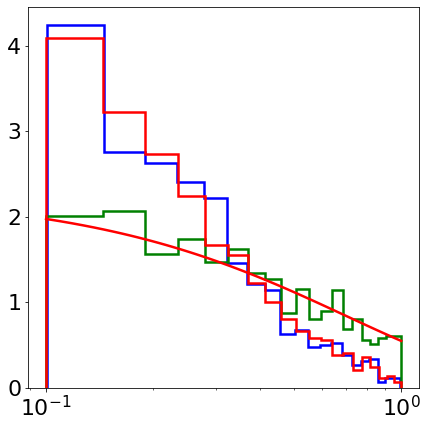

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

radius = np.linspace(0.1, 1., 100)
from scipy.integrate import quad
A = quad(rho, 0.1, 1., args=(0., np.pi/2., ))
ax.plot(radius, rho(radius, 0., np.pi/2.)/A[0], color="red", lw=2.5)
#r = spatial_sampling(1000)
_, _, _ = ax.hist(r, histtype="step", linewidth=2.5, color="blue", density=True, bins=20)
_, _, _ = ax.hist(r0, histtype="step", linewidth=2.5, color="g", density=True, bins=20)
_, _, _ = ax.hist(r1, histtype="step", linewidth=2.5, color="red", density=True, bins=20)

ax.set_xscale("log")

# Update ATMO input files

In [ ]:
import glob

# load theoretical BD cooling model - ATMO 2020
path =  "/home/mariacst/cluster/data/"
#path = "/Users/mariabenito/Dropbox/exoplanets/DM/python/cluster/data/"
#path  = path 
M     = []
age   = {}
Teff  = {}
files = glob.glob(path + "*.txt")
for file in files:
    data = np.genfromtxt(file, unpack=True)
    age[data[0][0]]  = data[1] # age [Gyr]
    Teff[data[0][0]] = data[2] # Teff [K]
    M.append(data[0][0])

_age   = np.linspace(1, 10, 100)
_age_i = []; _mass = []; _teff = []
# the first 5 masses do not have all values between 1 and 10 Gyr
M = np.sort(M)[5:] # further remove larger masses
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
points = np.transpose(np.asarray([_age_i, _mass]))
values = np.asarray(_teff)

print(points.shape)

_age_i = np.asarray(_age_i)
_mass  = np.asarray(_mass)
_teff  = np.asarray(_teff)

with open("ATMO_CEQ_vega_MIRI.txt", "w") as f:
    #f.write("#age[Gyr]  mass[]  T[K]")
    for a, m, T in zip(_age_i, _mass, _teff):
        f.write('%.6f %.6f %.6f\n' %(a, m, T))

# Limiting minimum temperature/dust obscuration

In [2]:
from mock_generation import mock_population, mock_population_sens

In [3]:
relT=0.1; relM=0.1; f=1.; g=0.; rs=20.
r1, T1, m1, a1 = mock_population(1000, relT, relM, f, g, rs)
r2, T2, m2, a2 = mock_population(10000, relT, relM, f, g, rs)
r3, T3, m3, a3 = mock_population(100000, relT, relM, f, g, rs)

In [4]:
pos1 = np.where(T1<650.)
pos2 = np.where(T2<650.)
pos3 = np.where(T3<650.)

print(len(pos1[0]), len(pos1[0])/len(T1))
print(len(pos2[0]), len(pos2[0])/len(T2))
print(len(pos3[0]), len(pos3[0])/len(T3))

554 0.554
5809 0.5809
57124 0.57124


In [57]:
pos1 = np.where(T1<650.)
pos2 = np.where(T2<650.)
pos3 = np.where(T3<650.)

print(len(pos1[0]), len(pos1[0])/len(T1))
print(len(pos2[0]), len(pos2[0])/len(T2))
print(len(pos3[0]), len(pos3[0])/len(T3))

553 0.553
5611 0.5611
57317 0.57317


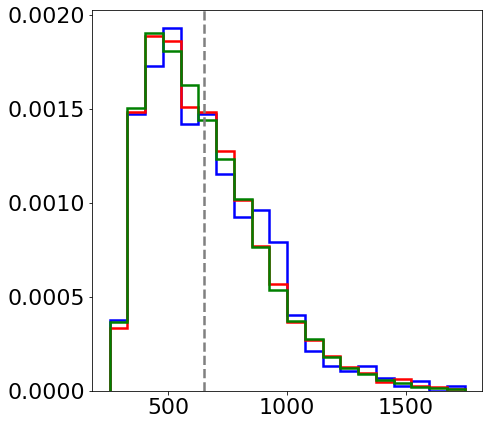

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.axvline(650, color="grey", lw=2.5, ls="--")
_, bins, _ = ax.hist(T1, bins=20, histtype="step", color="blue", lw=2.5, density=True)
_, _, _ = ax.hist(T2, bins=bins, histtype="step", color="red", lw=2.5, density=True)
_, _, _ = ax.hist(T3, bins=bins, histtype="step", color="green", lw=2.5, density=True)

In [59]:
relT=0.1; relM=0.1; f=1.; g=1.5; rs=5.

r1, T1, m1, a1 = mock_population(1000, relT, relM, f, g, rs)
r2, T2, m2, a2 = mock_population(10000, relT, relM, f, g, rs)
r3, T3, m3, a3 = mock_population(100000, relT, relM, f, g, rs)

In [60]:
pos1 = np.where(T1<650.)
pos2 = np.where(T2<650.)
pos3 = np.where(T3<650.)

print(len(pos1[0]), len(pos1[0])/len(T1))
print(len(pos2[0]), len(pos2[0])/len(T2))
print(len(pos3[0]), len(pos3[0])/len(T3))

335 0.335
3431 0.3431
33969 0.33969


In [128]:
from mock_generation import mock_population

relT=0.1; relM=0.1; f=1.; g=0.; rs=20.
r1, T1, m1, a1 = mock_population(int(4.5*1000), relT, relM, f, g, rs)
r2, T2, m2, a2 = mock_population(int(4.5*10000), relT, relM, f, g, rs)
r3, T3, m3, a3 = mock_population(int(4.5*100000), relT, relM, f, g, rs)

In [88]:
Tmin = 650.
pos  = np.where((m1 > 0.013) & (m1 < 0.053) & (T1 > Tmin))
r1 = r1[pos]
T1 = T1[pos]
m1 = m1[pos]
a1 = a1[pos]
T1.shape

(1188,)

In [89]:
Tmin = 650.
pos  = np.where((m2 > 0.013) & (m2 < 0.053) & (T2 > Tmin))
r2 = r2[pos]
T2 = T2[pos]
m2 = m2[pos]
a2 = a2[pos]
T2.shape

(11486,)

In [90]:
Tmin = 650.
pos  = np.where((m3 > 0.013) & (m3 < 0.053) & (T3 > Tmin))
r3 = r3[pos]
T3 = T3[pos]
m3 = m3[pos]
a3 = a3[pos]
T3.shape

(116039,)

In [93]:
len(pos[0])

116039

In [94]:
from mock_generation import mock_population

In [101]:
relT=0.1; relM=0.1; f=1.; g=0.; rs=20.
r1, T1, m1, a1 = mock_population(1000, relT, relM, f, g, rs, 0.42, 650.)
r2, T2, m2, a2 = mock_population(10000, relT, relM, f, g, rs, 650.)
r3, T3, m3, a3 = mock_population(100000, relT, relM, f, g, rs, 650.)
print(r1.shape, r2.shape, r3.shape)

holi
holi
holi
(1000,) (10000,) (100000,)


In [124]:
imp.reload(mock_generation)
from mock_generation import mock_population_sens
path =  "./data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
#print(points, values)

In [125]:
Tobs, Teff = mock_population_sens(1000, relT, relM, points, values, f, g, rs, 0.42, 650.)

(array([ 16., 236., 252., 187., 111.,  93.,  38.,  25.,  13.,  14.]),
 array([ 560.16091988,  657.43990193,  754.71888398,  851.99786603,
         949.27684808, 1046.55583014, 1143.83481219, 1241.11379424,
        1338.39277629, 1435.67175834, 1532.95074039]),
 [<matplotlib.patches.Polygon at 0x7fdfb65fd438>])

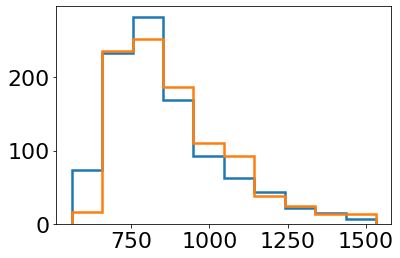

In [126]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(Teff, histtype="step", lw=2.5)
ax.hist(Tobs, bins=bins, histtype="step", lw=2.5)

In [1]:
import sys
sys.path.append("../../../Tmin/")
#sys.path.append("../python/cluster")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.palettes
import imp
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM

from matplotlib import rc
rc('font', family='times new roman', size=22.)

In [2]:
mock_population?

In [ ]:
for i in range(40):
    robs, Tobs, mass, age = mock_population(100000, 0.1, 0.2, 1., 0., 5., 0.42, 650.)

Tmin =  650.0 110762
Tmin =  650.0 110579
Tmin =  650.0 110274
Tmin =  650.0 110329
Tmin =  650.0 111202
Tmin =  650.0 110335
Tmin =  650.0 111019
Tmin =  650.0 110539
Tmin =  650.0 110865
Tmin =  650.0 110702
Tmin =  650.0 110888
Tmin =  650.0 110902
Tmin =  650.0 110681
Tmin =  650.0 110123
Tmin =  650.0 110625
Tmin =  650.0 110275
Tmin =  650.0 110597
Tmin =  650.0 110923
Tmin =  650.0 110606
Tmin =  650.0 110717


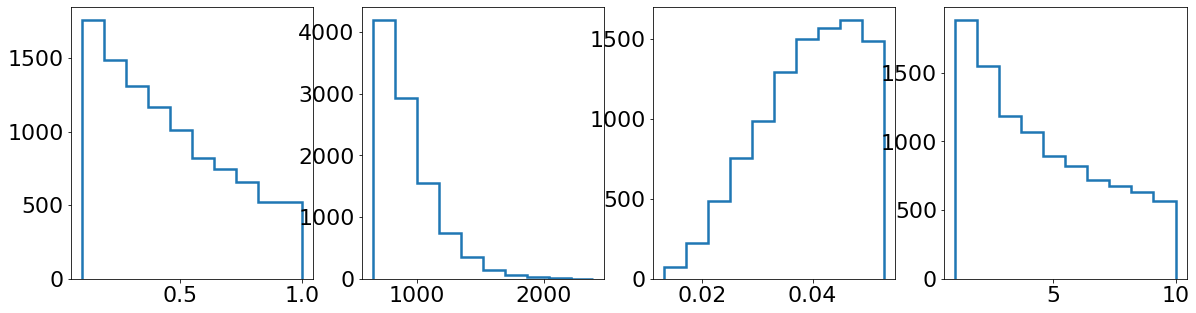

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

_, _, _ = ax[0].hist(robs, histtype="step", lw=2.5)
_, _, _ = ax[1].hist(Tobs, histtype="step", lw=2.5)
_, _, _ = ax[2].hist(mass, histtype="step", lw=2.5)
_, _, _ = ax[3].hist(age, histtype="step", lw=2.5)

# Check mock population with uncertainties in all variables

In [3]:
mock_population_all?

In [45]:
N=100
relT=0.10; relM=0.10; relRobs=0.20; relA=0.20
f = 1.; gamma = 1.; rs=20.

In [46]:
robs_wn, Tobs, mass, ages_wn, robs, ages = mock_population_all(N, relT, relM, relRobs, relA, f, gamma, rs)

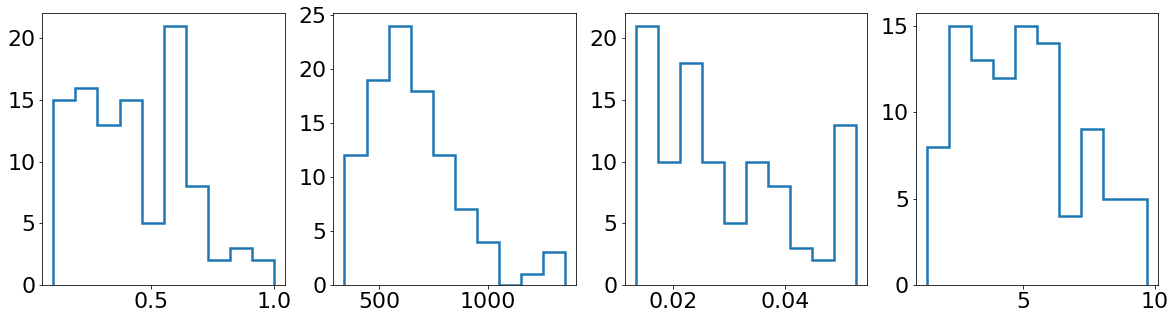

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

_, _, _ = ax[0].hist(robs_wn, histtype="step", lw=2.5)
_, _, _ = ax[1].hist(Tobs, histtype="step", lw=2.5)
_, _, _ = ax[2].hist(mass, histtype="step", lw=2.5)
_, _, _ = ax[3].hist(ages_wn, histtype="step", lw=2.5)

-0.024166101424088787 20.721559773563428


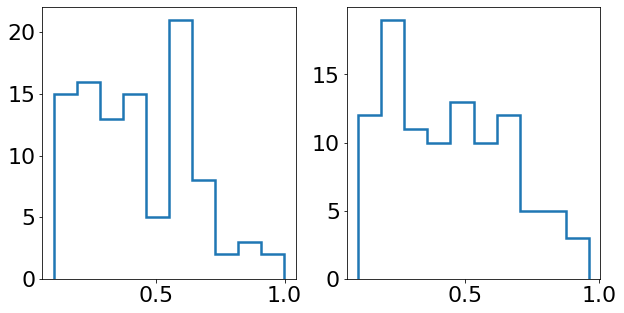

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_, _, _ = ax[0].hist(robs_wn, histtype="step", lw=2.5)
_, _, _ = ax[1].hist(robs, histtype="step", lw=2.5)
print(np.mean((robs_wn-robs)/robs), np.std((robs_wn-robs)/robs)*100)

0.015079895718686334 18.67047080081808


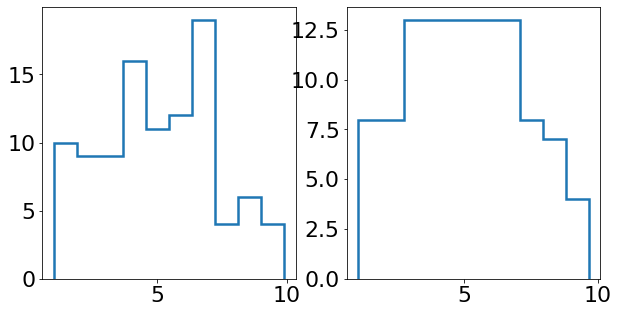

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_, _, _ = ax[0].hist(ages_wn, histtype="step", lw=2.5)
_, _, _ = ax[1].hist(ages, histtype="step", lw=2.5)
print(np.mean((ages_wn-ages)/ages), np.std((ages_wn-ages)/ages)*100)